We will now train the basic model from #2 on one of the stratified folds we created in #3. This will give us a framework we will be able to leverage with some consistency to evaluate model performance (and the impact of various preprocessing techniques).

In [1]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

from pathlib import Path
import pandas as pd
import numpy as np
import librosa

In [2]:
trn_df = pd.read_csv('data/train_with_splits.csv')
trn_df_idx = pd.read_csv('data/train.csv').set_index('fname') 

trn_paths = list(Path('data/audio_train_22k/').iterdir())
tst_paths = list(Path('data/audio_test_22k/').iterdir())

splits = pd.read_pickle('data/splits.pkl')

mean_std = 0.077

def open_audio_file(path):
    x, sr = librosa.core.load(path, sr=None)
    # grabbing first 2 seconds of audio and padding with 0s if too short
    return np.pad(x, (0, 22050*2), 'constant')[:22050*2].reshape(1, -1)

def item_to_label(path): return trn_df_idx.loc[path.name].label
tfms = [[open_audio_file], [item_to_label, Categorize()]]

class TensorAudio(TensorBase): pass

@ToTensor
def encodes(self, o:np.ndarray): return TensorAudio(o)

@Normalize
def encodes(self, o:TensorAudio): return o / self.std

item_audio_tfms = [ToTensor()]

trn_dir = 'data/audio_train_22k'
trn_paths = []

for fn in trn_df.fname: trn_paths.append(Path(f'{trn_dir}/{fn}'))

def get_databunch(split_num=0):
    dsrc = DataSource(trn_paths, tfms, splits=splits[split_num])

    batch_tfms = [Cuda(), Normalize(std=mean_std)]
    return dsrc.databunch(after_item=item_audio_tfms, after_batch=batch_tfms, bs=128, num_workers=12)

dbch = get_databunch()

def get_learner():
    def conv_block(in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Conv1d(out_channels, out_channels, kernel_size),
            nn.ReLU(),
            nn.BatchNorm1d(out_channels),
        )


    def pool_and_dropout_block(pool_size):
        return nn.Sequential(
            nn.MaxPool1d(pool_size),
            nn.Dropout(0.1)
        )

    def fc_block(in_features, out_features):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            nn.BatchNorm1d(out_features),
        )

    arch = nn.Sequential(
        conv_block(1, 16, 9),
        pool_and_dropout_block(16),
        conv_block(16, 32, 3),
        pool_and_dropout_block(4),
        conv_block(32, 64, 3),
        pool_and_dropout_block(4),
        conv_block(64, 128, 3),
        nn.AdaptiveAvgPool1d(1),
        Flatten(),
        fc_block(128, 128),
        fc_block(128, 128),
        nn.Linear(128, dbch.c)
    )

    def top_3_accuracy(preds, targs): return top_k_accuracy(preds, targs, 3)

    return Learner(
        dbch, arch, metrics=[accuracy, top_3_accuracy],
        opt_func=partial(Adam, wd=0.01, eps=1e-3)
    )

In [3]:
learn = get_learner()

In [4]:
learn.fit_one_cycle(30, 3e-3)

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.387560,3.389785,0.117525,0.257930,00:16
1,3.032873,3.510635,0.148206,0.286531,00:12
2,2.713324,3.625146,0.166927,0.307852,00:12
3,2.487275,2.719668,0.266771,0.501300,00:12
4,2.302307,2.908159,0.283931,0.502860,00:12
5,2.153861,2.519934,0.355694,0.598544,00:12
6,2.054533,2.525200,0.337494,0.566823,00:12
7,1.935099,2.535805,0.352054,0.572543,00:12
8,1.827657,2.311510,0.410816,0.640146,00:12
9,1.720831,2.346291,0.414977,0.650026,00:12


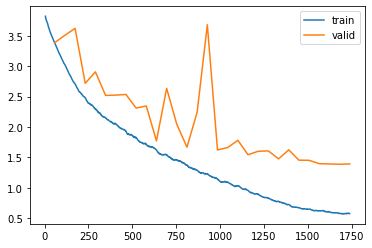

In [5]:
learn.recorder.plot_loss()

In [6]:
learn.save('simple')

In [7]:
def create_submission_and_submit(sub_name):
    preds = learn.get_preds(dl=test_dl(dbch, tst_paths))[0]
    predicted_label_idxs = preds.argsort(descending=True)[:, :3]
    
    fns, predicted_labels = [], []

    for path, idxs in zip(tst_paths, predicted_label_idxs):
        fns.append(path.name)
        predicted_labels.append([dbch.vocab[idx] for idx in idxs])
        
    sub = pd.DataFrame({'fname': fns, 'label': predicted_labels})
    sub.label = sub.label.apply(lambda lst: ' '.join(lst))
    sub.to_csv(f'data/submissions/{sub_name}.csv.zip', compression='zip', index=False)
    
    !kaggle competitions submit -c freesound-audio-tagging -f data/submissions/{sub_name}.csv.zip -m {sub_name}

In [8]:
create_submission_and_submit('simple')

100%|██████████████████████████████████████| 89.8k/89.8k [00:03<00:00, 23.6kB/s]
Successfully submitted to Freesound General-Purpose Audio Tagging Challenge

This submission would achieve a private score of ~0.73 which would be around place 450 on the LB.

Just to satisfy our curiosity (and also because this is a useful reference point to have), let's quickly see how averaging predictions from models trained on 5 folds would perform.

In [9]:
preds = []

for split_idx in range(5):
    dbch = get_databunch(split_idx)
    learn = get_learner()
    learn.fit_one_cycle(30, 3e-3)
    preds.append(learn.get_preds(dl=test_dl(dbch, tst_paths))[0])

epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.407755,3.519181,0.119605,0.244410,00:13
1,3.052855,3.126169,0.196568,0.359334,00:12
2,2.726875,3.265187,0.197608,0.401456,00:12
3,2.452888,3.999176,0.165367,0.332813,00:12
4,2.298790,7.445421,0.157566,0.326573,00:12
5,2.163311,2.834915,0.260010,0.490380,00:12
6,2.063597,2.319369,0.373895,0.618825,00:12
7,1.928856,3.753881,0.221009,0.429017,00:12
8,1.824515,3.251446,0.304732,0.528861,00:12
9,1.702732,2.306543,0.455018,0.678107,00:12


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.340136,3.568831,0.119372,0.226178,00:13
1,2.960922,3.741256,0.164921,0.315707,00:12
2,2.629529,4.034464,0.172251,0.311518,00:12
3,2.382786,3.267676,0.213089,0.394241,00:12
4,2.224820,2.557409,0.308901,0.542408,00:12
5,2.089956,3.059217,0.289529,0.492670,00:12
6,1.961623,3.517004,0.240838,0.426702,00:12
7,1.827975,2.321619,0.396335,0.611518,00:12
8,1.725121,2.113645,0.462304,0.669110,00:12
9,1.616136,3.566512,0.295288,0.527225,00:12


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.358935,3.439794,0.113048,0.240887,00:13
1,2.999580,3.971192,0.145800,0.278394,00:12
2,2.682409,3.389415,0.203909,0.396725,00:12
3,2.433845,2.942806,0.274696,0.493925,00:12
4,2.228569,2.715785,0.304807,0.525621,00:12
5,2.092274,2.712059,0.310618,0.527734,00:12
6,1.988500,2.383674,0.389329,0.622293,00:12
7,1.867664,2.771277,0.312203,0.527205,00:12
8,1.756492,2.251814,0.408875,0.650291,00:12
9,1.665945,2.040563,0.450079,0.676704,00:12


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.332376,3.370327,0.128518,0.284652,00:13
1,2.961040,3.302861,0.185343,0.361657,00:12
2,2.617435,3.333288,0.209772,0.375996,00:12
3,2.390732,3.090877,0.219331,0.433351,00:12
4,2.225308,3.586975,0.201806,0.391397,00:12
5,2.120468,3.388074,0.236325,0.418481,00:12
6,1.998052,2.689671,0.272438,0.521508,00:12
7,1.898883,2.946110,0.317578,0.546999,00:12
8,1.764686,2.418216,0.375996,0.609134,00:12
9,1.653207,2.217289,0.419543,0.659586,00:12


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,3.361535,3.729569,0.084227,0.196352,00:13
1,3.018951,3.890617,0.108369,0.262339,00:12
2,2.706203,2.877358,0.241953,0.467811,00:12
3,2.448119,2.774497,0.275751,0.485515,00:12
4,2.272221,3.242357,0.194742,0.429185,00:12
5,2.133831,2.558350,0.335837,0.586373,00:12
6,2.021220,3.129668,0.255365,0.463519,00:12
7,1.888921,4.234981,0.230687,0.425429,00:12
8,1.760116,2.350184,0.400751,0.646459,00:12
9,1.666251,2.089700,0.453863,0.675429,00:12


In [10]:
sub_name = 'simple_mean_of_5_folds'

In [11]:
predicted_label_idxs = torch.stack(preds).mean(0).argsort(descending=True)[:, :3]
    
fns, predicted_labels = [], []

for path, idxs in zip(tst_paths, predicted_label_idxs):
    fns.append(path.name)
    predicted_labels.append([dbch.vocab[idx] for idx in idxs])

sub = pd.DataFrame({'fname': fns, 'label': predicted_labels})
sub.label = sub.label.apply(lambda lst: ' '.join(lst))
sub.to_csv(f'data/submissions/{sub_name}.csv.zip', compression='zip', index=False)

!kaggle competitions submit -c freesound-audio-tagging -f data/submissions/{sub_name}.csv.zip -m {sub_name}

100%|██████████████████████████████████████| 89.6k/89.6k [00:03<00:00, 23.7kB/s]
Successfully submitted to Freesound General-Purpose Audio Tagging Challenge

A submission based on predictions averaged from 5 folds achieves around `0.796` on the LB, which is a jump of nearly 120 places to a position around 330.

Same architecture and an over 25% drop in error rate!